In [1]:
# import relevant modules
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn


from imblearn.over_sampling import RandomOverSampler 
from collections import Counter


import warnings
warnings.filterwarnings('ignore')


In [2]:
# Dataset field names
datacols = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]

# Load NSL_KDD train dataset
dfkdd_train = pd.read_csv('C:/Users/DELL/Desktop/Unauthorized Access Point Detection Using Machine Learning Algorithms for Information Protection/CODE/code/train_kddcup.csv', sep=",", names=datacols) # change path to where the dataset is located.
dfkdd_train = dfkdd_train.iloc[:,:-1] # removes an unwanted extra field

# Load NSL_KDD test dataset
dfkdd_test = pd.read_csv('C:/Users/DELL/Desktop/Unauthorized Access Point Detection Using Machine Learning Algorithms for Information Protection/CODE/code/test_kddcup.csv', sep=",", names=datacols)
dfkdd_test = dfkdd_test.iloc[:,:-1]

In [3]:
# View train data
dfkdd_train.head(3)

# train set dimension
print('Train set dimension: {} rows, {} columns'.format(dfkdd_train.shape[0], dfkdd_train.shape[1]))

Train set dimension: 125973 rows, 42 columns


In [4]:
# View test data
dfkdd_test.head(3)

# test set dimension
print('Test set dimension: {} rows, {} columns'.format(dfkdd_test.shape[0], dfkdd_test.shape[1]))


Test set dimension: 22544 rows, 42 columns


In [5]:
mapping = {'ipsweep': 'Probe','satan': 'Probe','nmap': 'Probe','portsweep': 'Probe','saint': 'Probe','mscan': 'Probe',
        'teardrop': 'DoS','pod': 'DoS','land': 'DoS','back': 'DoS','neptune': 'DoS','smurf': 'DoS','mailbomb': 'DoS',
        'udpstorm': 'DoS','apache2': 'DoS','processtable': 'DoS',
        'perl': 'U2R','loadmodule': 'U2R','rootkit': 'U2R','buffer_overflow': 'U2R','xterm': 'U2R','ps': 'U2R',
        'sqlattack': 'U2R','httptunnel': 'U2R',
        'ftp_write': 'R2L','phf': 'R2L','guess_passwd': 'R2L','warezmaster': 'R2L','warezclient': 'R2L','imap': 'R2L',
        'spy': 'R2L','multihop': 'R2L','named': 'R2L','snmpguess': 'R2L','worm': 'R2L','snmpgetattack': 'R2L',
        'xsnoop': 'R2L','xlock': 'R2L','sendmail': 'R2L',
        'normal': 'Normal'
        }

In [6]:
# Apply attack class mappings to the dataset

dfkdd_train['attack_class'] = dfkdd_train['attack'].apply(lambda v: mapping[v])
dfkdd_test['attack_class'] = dfkdd_test['attack'].apply(lambda v: mapping[v])

In [7]:
# Drop attack field from both train and test data
dfkdd_train.drop(['attack'], axis=1, inplace=True)
dfkdd_test.drop(['attack'], axis=1, inplace=True)

In [8]:
# View top 3 train data 
dfkdd_train.head(3)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,Normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.0,0.0,0.0,0.00,0.0,Normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.0,1.0,1.0,0.00,0.0,DoS


In [9]:
dfkdd_train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,...,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,...,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
dfkdd_train['num_outbound_cmds'].value_counts()
dfkdd_test['num_outbound_cmds'].value_counts()

0    22544
Name: num_outbound_cmds, dtype: int64

In [11]:
# 'num_outbound_cmds' field has all 0 values. Hence, it will be removed from both train and test dataset since it is a redundant field.
dfkdd_train.drop(['num_outbound_cmds'], axis=1, inplace=True)
dfkdd_test.drop(['num_outbound_cmds'], axis=1, inplace=True)

In [12]:
# Attack Class Distribution
attack_class_freq_train = dfkdd_train[['attack_class']].apply(lambda x: x.value_counts())
attack_class_freq_test = dfkdd_test[['attack_class']].apply(lambda x: x.value_counts())
attack_class_freq_train['frequency_percent_train'] = round((100 * attack_class_freq_train / attack_class_freq_train.sum()),2)
attack_class_freq_test['frequency_percent_test'] = round((100 * attack_class_freq_test / attack_class_freq_test.sum()),2)

attack_class_dist = pd.concat([attack_class_freq_train,attack_class_freq_test], axis=1) 
attack_class_dist

,attack_class,frequency_percent_train,attack_class,frequency_percent_test
DoS,45927,36.46,7458,33.08
Normal,67343,53.46,9711,43.08
Probe,11656,9.25,2421,10.74
R2L,995,0.79,2754,12.22
U2R,52,0.04,200,0.89


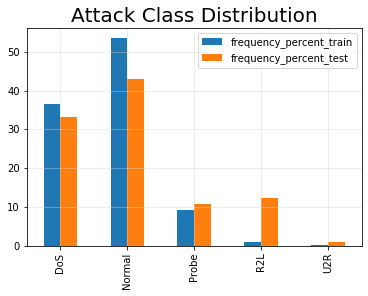

In [13]:
# Attack class bar plot
plot = attack_class_dist[['frequency_percent_train', 'frequency_percent_test']].plot(kind="bar");
plot.set_title("Attack Class Distribution", fontsize=20);
plot.grid(color='lightgray', alpha=0.5);

In [14]:
dfkdd_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,Normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,Normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,DoS
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,Normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Normal


In [15]:
#SCALING NUMERICAL ATTRIBUTES

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# extract numerical attributes and scale it to have zero mean and unit variance  
cols = dfkdd_train.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(dfkdd_train.select_dtypes(include=['float64','int64']))
sc_test = scaler.fit_transform(dfkdd_test.select_dtypes(include=['float64','int64']))

# turn the result back to a dataframe
sc_traindf = pd.DataFrame(sc_train, columns = cols)
sc_testdf = pd.DataFrame(sc_test, columns = cols)


In [16]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# extract categorical attributes from both training and test sets 
cattrain = dfkdd_train.select_dtypes(include=['object']).copy()
cattest = dfkdd_test.select_dtypes(include=['object']).copy()

# encode the categorical attributes
traincat = cattrain.apply(encoder.fit_transform)
testcat = cattest.apply(encoder.fit_transform)

# separate target column from encoded data 
enctrain = traincat.drop(['attack_class'], axis=1)
enctest = testcat.drop(['attack_class'], axis=1)

cat_Ytrain = traincat[['attack_class']].copy()
cat_Ytest = testcat[['attack_class']].copy()

In [17]:
#DATA SAMPLING

from imblearn.over_sampling import RandomOverSampler 
from collections import Counter

# define columns and extract encoded train set for sampling 
sc_traindf = dfkdd_train.select_dtypes(include=['float64','int64'])
refclasscol = pd.concat([sc_traindf, enctrain], axis=1).columns
refclass = np.concatenate((sc_train, enctrain.values), axis=1)

X = refclass

# reshape target column to 1D array shape  
c, r = cat_Ytest.values.shape
y_test = cat_Ytest.values.reshape(c,)

c, r = cat_Ytrain.values.shape
y = cat_Ytrain.values.reshape(c,)

# apply the random over-sampling
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_sample(X, y)
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({1: 67343, 0: 45927, 2: 11656, 3: 995, 4: 52})
Resampled dataset shape Counter({1: 67343, 0: 67343, 3: 67343, 2: 67343, 4: 67343})


In [18]:
#DATASET PARTITION

# define columns to new dataframe
newcol = list(refclasscol)
newcol.append('attack_class')

# add a dimension to target
new_y_res = y_res[:, np.newaxis]

# create a dataframe from sampled data
res_arr = np.concatenate((X_res, new_y_res), axis=1)
res_df = pd.DataFrame(res_arr, columns = newcol) 
print(res_df)

# create test dataframe
reftest = pd.concat([sc_testdf, testcat], axis=1)
reftest['attack_class'] = reftest['attack_class'].astype(np.float64)
reftest['protocol_type'] = reftest['protocol_type'].astype(np.float64)
reftest['flag'] = reftest['flag'].astype(np.float64)
reftest['service'] = reftest['service'].astype(np.float64)

res_df.shape
reftest.shape

        duration  src_bytes  dst_bytes      land  wrong_fragment    urgent  \
0      -0.110249  -0.007679  -0.004919 -0.014089       -0.089486 -0.007736   
1      -0.110249  -0.007737  -0.004919 -0.014089       -0.089486 -0.007736   
2      -0.110249  -0.007762  -0.004919 -0.014089       -0.089486 -0.007736   
3      -0.110249  -0.007723  -0.002891 -0.014089       -0.089486 -0.007736   
4      -0.110249  -0.007728  -0.004814 -0.014089       -0.089486 -0.007736   
...          ...        ...        ...       ...             ...       ...   
336710 -0.110249  -0.007762  -0.003517 -0.014089       -0.089486 -0.007736   
336711 -0.042674  -0.007497  -0.004239 -0.014089       -0.089486 -0.007736   
336712 -0.110249  -0.007762  -0.003469 -0.014089       -0.089486 -0.007736   
336713 -0.110249  -0.007762  -0.004403 -0.014089       -0.089486 -0.007736   
336714 -0.086828  -0.007712  -0.003942 -0.014089       -0.089486 -0.007736   

             hot  num_failed_logins  logged_in  num_compromised

(22544, 41)

In [19]:
#FINALIZE DATA PREPROCESSING FOR TRAINING

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

Xresdf = res_df 
newtest = reftest

Xresdfnew = Xresdf
Xtest_features = newtest


Xresdfnuma = Xresdfnew.drop(['service'], axis=1)
Xresdfcata = Xresdfnew[['service']].copy()

Xtestdfnuma = Xtest_features.drop(['service'], axis=1)
Xtestcata = Xtest_features[['service']].copy()

# Fit train data
enc.fit(Xresdfcata)

# Transform train data
X_train_1hotenc = enc.transform(Xresdfcata).toarray()
       
# Transform test data
X_test_1hotenc = enc.transform(Xtestcata).toarray()




Xresdfnumb = Xresdfnew.drop(['protocol_type'], axis=1)
Xresdfcatb = Xresdfnew[['protocol_type']].copy()

Xtestdfnumb = Xtest_features.drop(['protocol_type'], axis=1)
Xtestcatb = Xtest_features[['protocol_type']].copy()

# Fit train data
enc.fit(Xresdfcatb)

# Transform train data
X_train_2hotenc = enc.transform(Xresdfcatb).toarray()
       
# Transform test data
X_test_2hotenc = enc.transform(Xtestcatb).toarray()



Xresdfnumc = Xresdfnew.drop(['flag'], axis=1)
Xresdfcatc = Xresdfnew[['flag']].copy()

Xtestdfnumc = Xtest_features.drop(['flag'], axis=1)
Xtestcatc = Xtest_features[['flag']].copy()

# Fit train data
enc.fit(Xresdfcatc)

# Transform train data
X_train_3hotenc = enc.transform(Xresdfcatc).toarray()
       
# Transform test data
X_test_3hotenc = enc.transform(Xtestcatc).toarray()



X_train = np.concatenate((Xresdfnuma.values, X_train_1hotenc), axis=1)
X_test = np.concatenate((Xtestdfnuma.values, X_test_1hotenc), axis=1)

X_train = np.concatenate((Xresdfnumb.values, X_train_2hotenc), axis=1)
X_test = np.concatenate((Xtestdfnumb.values, X_test_2hotenc), axis=1)

X_train = np.concatenate((Xresdfnumc.values, X_train_3hotenc), axis=1)
X_test = np.concatenate((Xtestdfnumc.values, X_test_3hotenc), axis=1)

y_train = Xresdf[['attack_class']].copy()
c, r = y_train.values.shape
Y_train = y_train.values.reshape(c,)

y_test = newtest[['attack_class']].copy()
c, r = y_test.values.shape
Y_test = y_test.values.reshape(c,)

print(X_train)

print(Y_train)

print(X_test)

print(Y_test)

[[-0.11024922 -0.0076786  -0.00491864 ...  0.          1.
   0.        ]
 [-0.11024922 -0.00773737 -0.00491864 ...  0.          1.
   0.        ]
 [-0.11024922 -0.00776224 -0.00491864 ...  0.          0.
   0.        ]
 ...
 [-0.11024922 -0.00776224 -0.00346934 ...  0.          1.
   0.        ]
 [-0.11024922 -0.00776224 -0.00440338 ...  0.          1.
   0.        ]
 [-0.08682827 -0.00771216 -0.00394159 ...  0.          1.
   0.        ]]
[1. 1. 0. ... 4. 4. 4.]
[[-0.15553409 -0.02198811 -0.09689597 ...  0.          0.
   0.        ]
 [-0.15553409 -0.02198811 -0.09689597 ...  0.          0.
   0.        ]
 [-0.15411277  0.0054731  -0.09689597 ...  0.          1.
   0.        ]
 ...
 [-0.15553409  0.09337309  0.29492588 ...  0.          1.
   0.        ]
 [-0.15553409 -0.02189927 -0.0949166  ...  0.          1.
   0.        ]
 [-0.15553409 -0.02198811 -0.09689597 ...  0.          0.
   0.        ]]
[0. 0. 1. ... 0. 1. 2.]


In [20]:
#TRAIN MODELS

from sklearn.svm import SVC 
from sklearn.naive_bayes import BernoulliNB 
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

In [21]:
# Train KNeighborsClassifier Model
KNN_Classifier = KNeighborsClassifier()
KNN_Classifier.fit(X_train, Y_train)
accuracy = metrics.accuracy_score(Y_test, KNN_Classifier.predict(X_test))
accuracy

0.8115684882895671

In [22]:
pd.DataFrame({'Y_test':Y_test,'y_predict':KNN_Classifier.predict(X_test)})

,Y_test,y_predict
0,0.0,0.0
1,0.0,0.0
2,1.0,1.0
3,2.0,2.0
4,2.0,1.0
...,...,...
22539,1.0,1.0
22540,1.0,1.0
22541,0.0,0.0
22542,1.0,1.0


In [23]:
SVC_Classifier = SVC()
SVC_Classifier.fit(X_train, Y_train)
accuracy = metrics.accuracy_score(Y_test, SVC_Classifier.predict(X_test))
accuracy

0.8667938254080908

In [24]:
pd.DataFrame({'Y_test':Y_test,'y_predict':SVC_Classifier.predict(X_test)})

,Y_test,y_predict
0,0.0,0.0
1,0.0,0.0
2,1.0,1.0
3,2.0,2.0
4,2.0,2.0
...,...,...
22539,1.0,1.0
22540,1.0,1.0
22541,0.0,0.0
22542,1.0,1.0


In [25]:
mlp_classifier = MLPClassifier()
mlp_classifier.fit(X_train, Y_train)
accuracy = metrics.accuracy_score(Y_test, mlp_classifier.predict(X_test))
accuracy

0.9446859474804826

In [26]:
pd.DataFrame({'Y_test':Y_test,'y_predict':mlp_classifier.predict(X_test)})

,Y_test,y_predict
0,0.0,0.0
1,0.0,0.0
2,1.0,1.0
3,2.0,2.0
4,2.0,2.0
...,...,...
22539,1.0,1.0
22540,1.0,1.0
22541,0.0,0.0
22542,1.0,1.0
